In [42]:
import pandas as pd
import numpy as np
# from lvgp_pytorch.models import LVGPR
# from lvgp_pytorch.optim import noise_tune, fit_model_scipy
import matplotlib.pyplot as plt
from scipy.stats import differential_entropy, norm
import gpytorch
import torch

In [43]:
data_all = pd.read_pickle("D:/PSED/Jarvis_cfid/data_downselect.pkl")
cgcnn_features_all = pd.read_pickle('D:/PSED/Jarvis_cfid/cgcnn_features_sorted.pkl').feature
cgcnn_features = cgcnn_features_all.loc[data_all.index]
cgcnn_features = pd.Series([np.asarray(row) for row in cgcnn_features], index=data_all.index)

In [44]:
# Leave out samples as test set for moduli ML
n_iter = 2  # Total iterations of sampling
n_test = 5927
rand_seed = 42
data_test = data_all.sample(n=n_test, random_state=rand_seed)
data = data_all.drop(data_test.index, inplace=False)
features_test = cgcnn_features.loc[data_test.index]
features = cgcnn_features.loc[data.index]

In [45]:
n_unlabeled = 3000  # size of data left out as unlabeled
# Select all unstable orthorhombics -> unlabeled
select1 = data.loc[(data.crys == 'tetragonal') & (data.formation_energy_peratom > 0)]
remain1 = data.drop(select1.index, inplace=False)
# Randomly select others
select2 = remain1.sample(n=(n_unlabeled-select1.shape[0]), random_state=rand_seed)

data_l = remain1.drop(select2.index, inplace=False)
data_u = pd.concat([select1, select2])

# x = cgcnn feature vectors; y = formation energies
y_labeled = data_l.formation_energy_peratom
x_labeled = pd.DataFrame({'feature': features.loc[data_l.index], 'crys': data_l.crys})
y_unlabel = data_u.formation_energy_peratom
x_unlabel = pd.DataFrame({'feature': features.loc[data_u.index], 'crys': data_u.crys})

# Info entropy for every crystal sys, within labeled data
# entropies = dict.fromkeys(x_unlabel.crystal_system.unique())

entropies = dict.fromkeys(data.crys.unique())
for key in entropies:
    entropies[key] = differential_entropy(y_labeled[x_labeled.crys == key])
# Column = crystal sys, row = iteration
entropies = pd.DataFrame.from_dict([entropies])


In [46]:
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    

def train_GP(train_x, train_y, train_iter):
    # train_x = torch.tensor(train_x.values)
    # train_y = torch.tensor(train_y.values)
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GPModel(train_x, train_y, likelihood)
    model.train()
    likelihood.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    # marginal log likelihood loss
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(train_iter):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        # print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        #     i + 1, train_iter, loss.item(),
        #     model.covar_module.base_kernel.lengthscale.item(),
        #     model.likelihood.noise.item()
        # ))
        optimizer.step()

    return model, likelihood

# Expected improvement, maximizing y
def calculate_acf(pred_mean, pred_std, y_max):
    improve = pred_mean - y_max
    z_score = np.divide(improve, pred_std + 1e-9)
    acf = np.multiply(improve, norm.cdf(z_score)) + np.multiply(pred_std, norm.pdf(z_score))
    return acf

In [47]:
%%prun -s cumulative -q -l 10 -T prun0
n_sample = 1000  # Samples drawn for each unlabeled data point
conditional_entropy = []
for i in range(n_iter):
    # Find the lowest entropy class with unlabeled sample available

    available_sys = x_unlabel.crys.unique()
    # entropies_available = {key: entropies_curr[key] for key in available_sys}
    entropies_available = entropies.iloc[-1][available_sys]
    # lowest_h_sys = min(entropies_available, key=entropies_available.get)
    lowest_h_sys = entropies_available.idxmin()
    h_curr = entropies_available[lowest_h_sys]  # Incumbent target value 

    # Now only use the lowest entropy crystal system
    x_target_l = x_labeled.loc[x_labeled.crys == lowest_h_sys].copy()

    y_target_l = y_labeled.loc[x_target_l.index].copy()
    
    
    x_in = torch.tensor(np.stack(x_target_l.feature.values), dtype=torch.float)
    y_in = torch.tensor(y_target_l.values, dtype=torch.float)

    GP_model, GP_likelihood = train_GP(x_in, y_in, train_iter=100)
    x_target_u = x_unlabel.loc[x_unlabel.crys == lowest_h_sys].copy()
    
    # Acquisition function values for all unlabeled points
    acq_func = pd.Series(index=x_target_u.index, dtype=float)
    # Compute the new entropy mean and variance
    for index, row in x_target_u.iterrows():
        x_test = torch.tensor(row.feature[np.newaxis,:], dtype=torch.float)
        GP_model.eval()
        GP_likelihood.eval()
        f_preds = GP_model(x_test)
        y_samples = f_preds.sample(sample_shape=torch.Size([1000]))

        # Monte Carlo sampling the entropies if a sample is added into labeled
        # h_new = [differential_entropy(np.append(y_target_l.values, y_mc)) for y_mc in y_samples]
        y_with_new_sample = np.concatenate((np.tile(y_target_l.values, (1000,1)), y_samples.numpy()), axis=1)
        # y_with_new_sample = np.concatenate((np.tile(y_target_l.values, (1000,1)).T, y_samples.numpy().T))
        h_new = differential_entropy(y_with_new_sample, axis=1)
        # h_new = differential_entropy(y_with_new_sample)
        h_new_mean = np.mean(h_new)
        h_new_std = np.std(h_new)
        acq_func[index] = calculate_acf(h_new_mean, h_new_std, h_curr)
    
    # Select the unlabeled datapoint with max acq func
    next_sample_idx = acq_func.idxmax()
    # Evaluate the sample and add to dataset
    x_labeled = pd.concat([x_labeled, x_unlabel.loc[[next_sample_idx]]])
    y_labeled = pd.concat([y_labeled, y_unlabel.loc[[next_sample_idx]]])
    x_unlabel.drop(index=next_sample_idx, inplace=True)
    y_unlabel.drop(index=next_sample_idx, inplace=True)

    # entropies[lowest_h_sys] = differential_entropy(y_labeled[x_labeled['crystal_system'] == lowest_h_sys])
    entropies = pd.concat([entropies, entropies.iloc[-1].to_frame().transpose()], ignore_index=True)
    # Change the entropy of crystal sys with new data added
    entropies.iloc[-1][lowest_h_sys] = differential_entropy(y_labeled[x_labeled.crys == lowest_h_sys])

    # Calculate conditional entropy
    cond_entropy = 0
    for sys in x_labeled.crys.unique():
        cond_entropy += entropies.iloc[-1][sys] * np.sum(x_labeled.crys == sys)
    conditional_entropy.append(cond_entropy / len(x_labeled))

    if not i % 5:
        print("Iteration " + str(i) + " completed.")
    

Iteration 0 completed.
 
*** Profile printout saved to text file 'prun0'. 


In [51]:
x_target_l.values.shape

(599, 2)

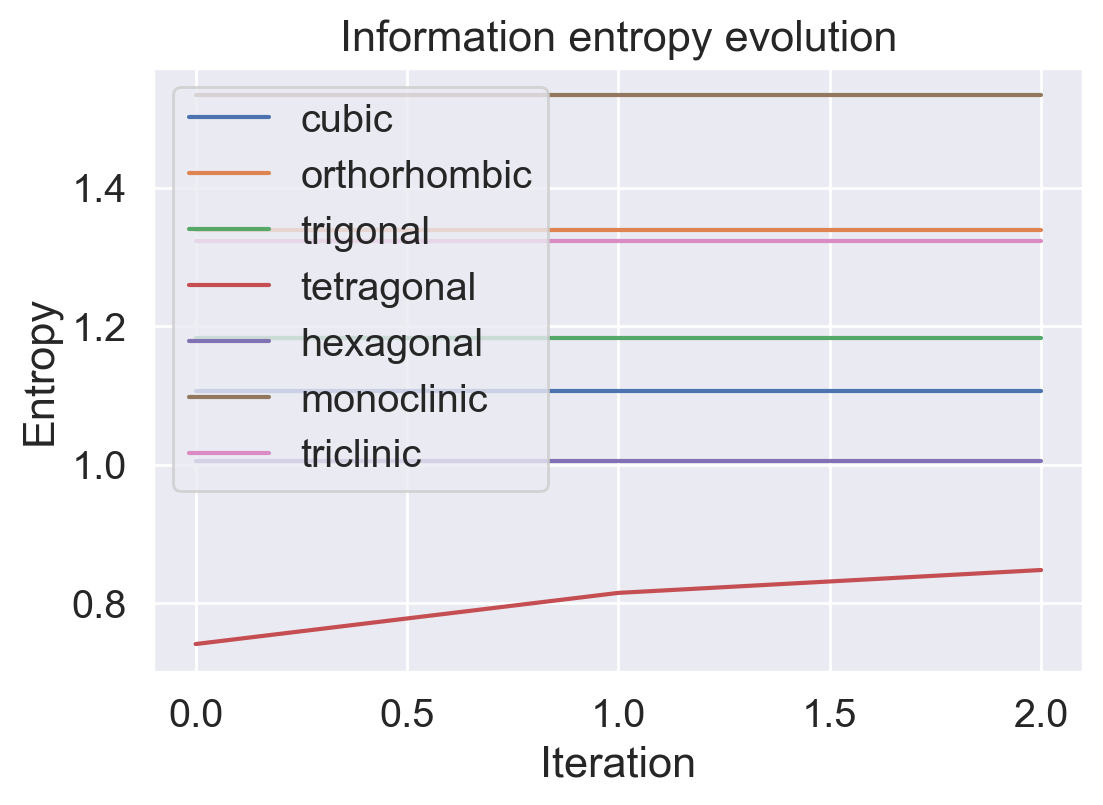

In [49]:
fig, ax = plt.subplots(dpi=200)

for col in entropies:
    ax.plot(entropies[col], label=col)
plt.legend(loc=2)
plt.title('Information entropy evolution')
plt.xlabel('Iteration')
plt.ylabel('Entropy')
# plt.show()
plt.savefig("D:/PSED/Entropy_evo.png")

ValueError: Could not interpret input 'crystal_system'

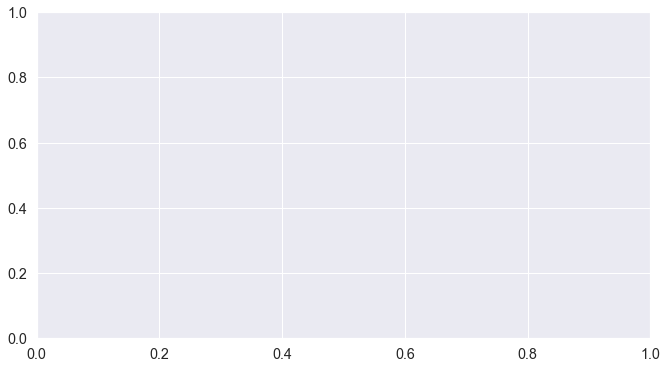

In [50]:
import seaborn as sns
sns.set(font_scale=1.3)
fig, ax = plt.subplots(figsize=(11,6))
order = ['cubic', 'hexagonal', 'trigonal', 'tetragonal', 'orthorhombic', 'monoclinic', 'triclinic']
sns.violinplot(data=data_l, x='crystal_system', y='energy', palette='Set3', bw=.2, cut=1, linewidth=1, order=order)
ax.set(ylim=(-.7,2))
plt.title('Distribution of energy - initial')
plt.savefig("D:/PSED/E_initial.png", dpi=200)

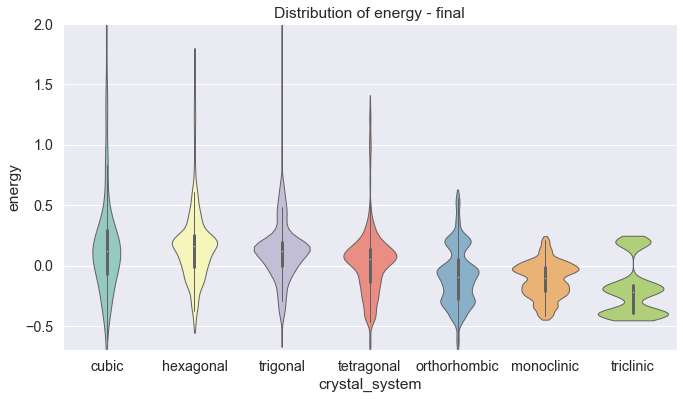

In [ ]:
sns.set(font_scale=1.3)
fig2, ax2 = plt.subplots(figsize=(11,6))
sns.violinplot(x=x_labeled['crystal_system'], y=y_labeled, order=order, palette='Set3', bw=.2, cut=1, linewidth=1)
ax2.set(ylim=(-.7,2))
plt.title('Distribution of energy - final')

plt.savefig("D:/PSED/E_final.png", dpi=200)

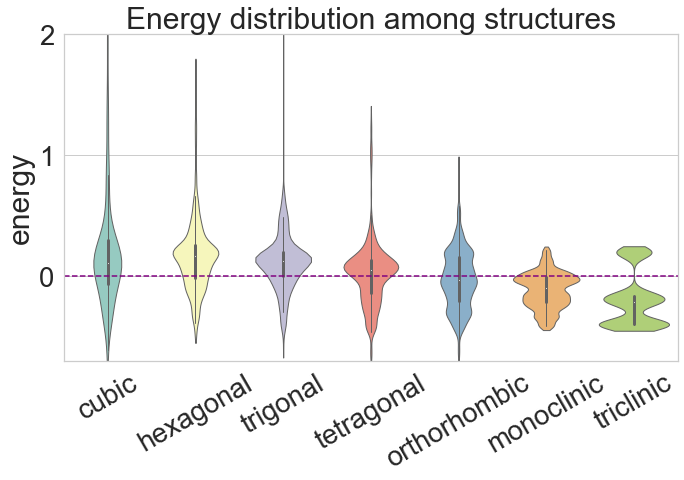

In [ ]:
# Distribution plot for whole dataset
import seaborn as sns
sns.set_theme(style="whitegrid", font_scale=2.5)
fig3, ax3 = plt.subplots(figsize=(11,6))
order = ['cubic', 'hexagonal', 'trigonal', 'tetragonal', 'orthorhombic', 'monoclinic', 'triclinic']
sns.violinplot(x='crystal_system', y='energy', data=data, order=order, palette='Set3', bw=.2, cut=1, linewidth=1)
ax3.set(ylim=(-.7,2))
ax3.set_xticklabels(ax3.get_xticklabels(), rotation = 30)
ax3.axhline(0, linestyle='--', color='purple')
plt.title('Energy distribution among structures')
plt.xlabel('')

plt.savefig("D:/PSED/E_final_whole.png", dpi=200, bbox_inches='tight')